In [ ]:
import sys, os
from pathlib import Path

ROOT = Path(os.getcwd()).resolve().parent  
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

print("Project root added to path successfully.")
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from joblib import dump

from src.data_utils import load_breast_cancer_df
from src.preprocess import build_preprocessor, split_features_target
from src.logistic_scratch import LogisticRegressionScratch
from src.logistic_sklearn import build_pipeline, grid_search_pipeline

sns.set_theme(style="whitegrid")
%matplotlib inline


Project root added to path: C:\Users\yajat\Code\Logistic_Regression-An_overview-1


In [9]:
df = load_breast_cancer_df()
print("Shape:", df.shape)
df.head()


Shape: (569, 31)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [10]:
display(df.info())
display(df.describe().T)

print("Missing values per column:")
display(df.isna().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

None

,count,mean,std,min,25%,50%,75%,max
mean radius,569.0,14.127292,3.524049,6.981000,11.700000,13.370000,15.780000,28.11000
mean texture,569.0,19.289649,4.301036,9.710000,16.170000,18.840000,21.800000,39.28000
mean perimeter,569.0,91.969033,24.298981,43.790000,75.170000,86.240000,104.100000,188.50000
mean area,569.0,654.889104,351.914129,143.500000,420.300000,551.100000,782.700000,2501.00000
mean smoothness,569.0,0.096360,0.014064,0.052630,0.086370,0.095870,0.105300,0.16340
mean compactness,569.0,0.104341,0.052813,0.019380,0.064920,0.092630,0.130400,0.34540
mean concavity,569.0,0.088799,0.079720,0.000000,0.029560,0.061540,0.130700,0.42680
mean concave points,569.0,0.048919,0.038803,0.000000,0.020310,0.033500,0.074000,0.20120
mean symmetry,569.0,0.181162,0.027414,0.106000,0.161900,0.179200,0.195700,0.30400
mean fractal dimension,569.0,0.062798,0.007060,0.049960,0.057700,0.061540,0.066120,0.09744


Missing values per column:


mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             0
fractal dimension error    0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
target                     0
dtype: int64

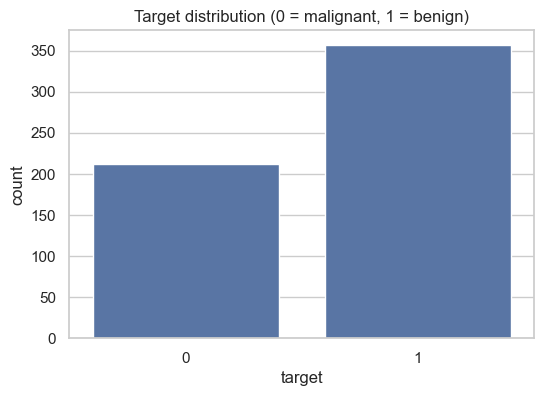

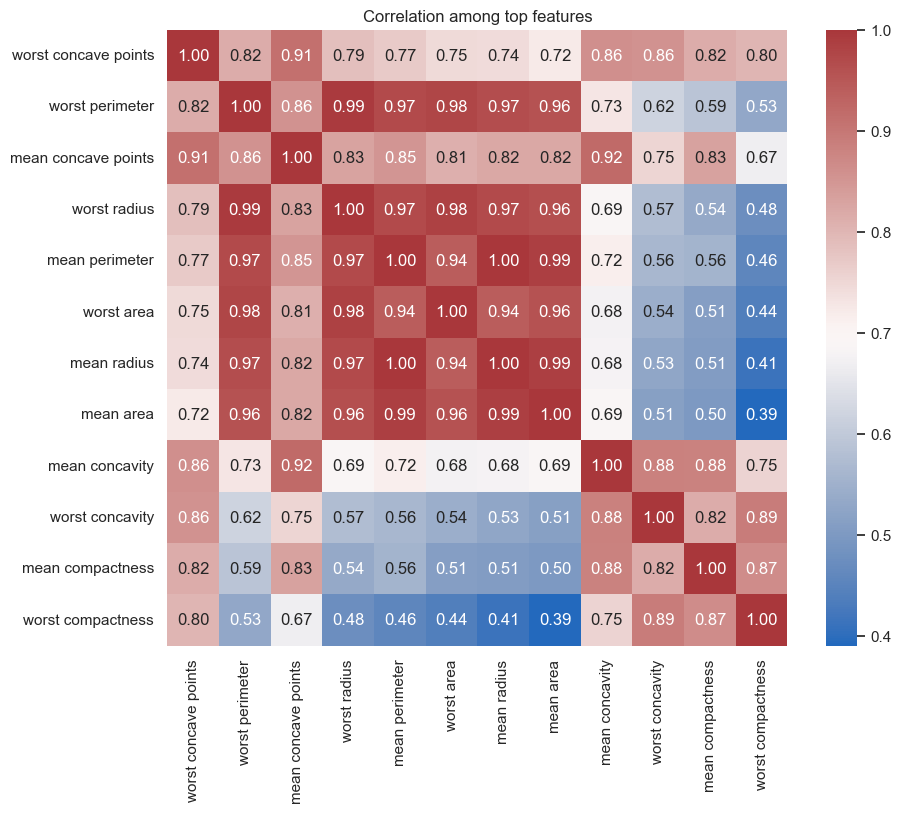

In [11]:
plt.figure(figsize=(6,4))
sns.countplot(x="target", data=df)
plt.title("Target distribution (0 = malignant, 1 = benign)")
plt.show()

corr = df.corr()
top_feats = corr['target'].abs().sort_values(ascending=False).index[1:13]  # skip target itself
plt.figure(figsize=(10,8))
sns.heatmap(df[top_feats].corr(), annot=True, fmt=".2f", cmap="vlag")
plt.title("Correlation among top features")
plt.show()


In [12]:
X, y = split_features_target(df, target_col="target")
numeric_features = list(X.select_dtypes(include=["int64","float64"]).columns)
categorical_features = [] 

preprocessor = build_preprocessor(numeric_features, categorical_features)
preprocessor


,transformers,"[('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (455, 30) Test: (114, 30)


In [14]:
pipe = build_pipeline(preprocessor, solver="liblinear", penalty="l2", C=1.0)

param_grid = {"clf__C":[0.01, 0.1, 1.0, 10.0]}
gs = grid_search_pipeline(pipe, X_train, y_train, param_grid=param_grid, cv=5, n_jobs=1, scoring="roc_auc")

print("Best params:", gs.best_params_)
best_pipeline = gs.best_estimator_

y_prob_sklearn = best_pipeline.predict_proba(X_test)[:,1]
y_pred_sklearn = best_pipeline.predict(X_test)

print("Sklearn model (test):")
print("Accuracy:", accuracy_score(y_test, y_pred_sklearn))
print("Precision:", precision_score(y_test, y_pred_sklearn))
print("Recall:", recall_score(y_test, y_pred_sklearn))
print("F1:", f1_score(y_test, y_pred_sklearn))
print("ROC AUC:", roc_auc_score(y_test, y_prob_sklearn))


Best params: {'clf__C': 1.0}
Sklearn model (test):
Accuracy: 0.9824561403508771
Precision: 0.9861111111111112
Recall: 0.9861111111111112
F1: 0.9861111111111112
ROC AUC: 0.9957010582010581


In [15]:
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

scratch = LogisticRegressionScratch(lr=0.1, n_iter=5000, l2=0.01, verbose=True)
scratch.fit(X_train_proc, y_train.values)

y_prob_scratch = scratch.predict_proba(X_test_proc)
y_pred_scratch = scratch.predict(X_test_proc)

print("Scratch model (test):")
print("Accuracy:", accuracy_score(y_test, y_pred_scratch))
print("Precision:", precision_score(y_test, y_pred_scratch))
print("Recall:", recall_score(y_test, y_pred_scratch))
print("F1:", f1_score(y_test, y_pred_scratch))
print("ROC AUC:", roc_auc_score(y_test, y_prob_scratch))


Scratch model (test):
Accuracy: 0.9736842105263158
Precision: 0.9859154929577465
Recall: 0.9722222222222222
F1: 0.9790209790209791
ROC AUC: 0.9950396825396826


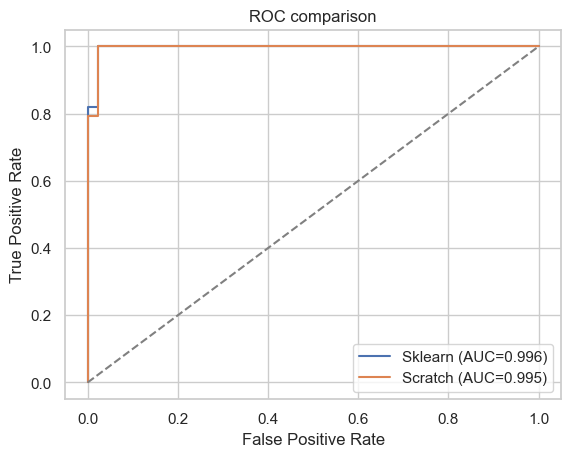

In [16]:
fpr_s, tpr_s, _ = roc_curve(y_test, y_prob_sklearn)
fpr_c, tpr_c, _ = roc_curve(y_test, y_prob_scratch)

plt.plot(fpr_s, tpr_s, label=f"Sklearn (AUC={roc_auc_score(y_test,y_prob_sklearn):.3f})")
plt.plot(fpr_c, tpr_c, label=f"Scratch (AUC={roc_auc_score(y_test,y_prob_scratch):.3f})")
plt.plot([0,1],[0,1], linestyle="--", color="grey")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC comparison")
plt.legend()
plt.show()


In [ ]:
feature_names = numeric_features  # with only numeric features

coef = best_pipeline.named_steps["clf"].coef_.ravel()
coef_df = pd.DataFrame({"feature": feature_names, "coef": coef})
coef_df = coef_df.reindex(coef_df.coef.abs().sort_values(ascending=False).index) 
coef_df.style.background_gradient(subset=["coef"], cmap="coolwarm")


In [19]:
model = best_pipeline
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]   


<module 'matplotlib.pyplot' from 'C:\\Users\\yajat\\AppData\\Roaming\\Python\\Python314\\site-packages\\matplotlib\\pyplot.py'>

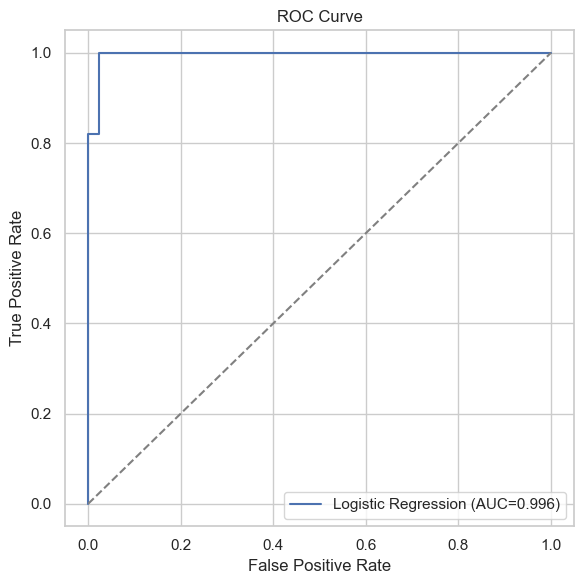

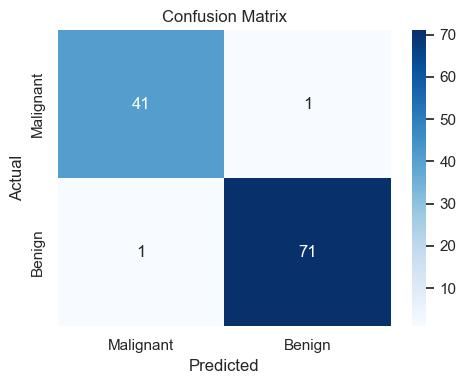

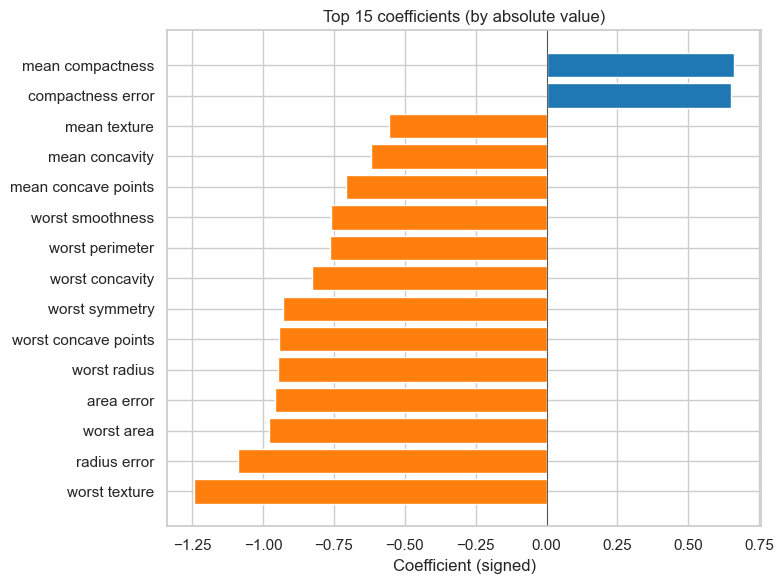

In [20]:
from src.visualize import plot_roc, plot_confusion, plot_coefficients

plot_roc(y_test, y_prob, label="Logistic Regression")
plot_confusion(y_test, y_pred, labels=["Malignant", "Benign"])
plot_coefficients(model.named_steps["clf"].coef_.ravel(), X.columns)


In [ ]:
os.makedirs("models", exist_ok=True)
dump(best_pipeline, "models/breast_cancer_model.joblib")
print("Saved sklearn pipeline to models/breast_cancer_model.joblib")
